In [6]:
from itertools import combinations 

import numpy as np
import gurobipy as gp
from gurobipy import GRB, quicksum

n_nodes = 100
n_edges = int(0.5 * (n_nodes * (n_nodes - 1)))
edge_pairs = list(combinations(range(n_nodes), 2))
# 01, 02, 03, 04, 12, 13, 14, 23, 24, 34
#w = np.array([93, 88, 86, 84, 81, 80, 79, 74, 72, 74])
w = 100 * np.random.rand(n_edges)
size = 5

# Create a new model
m = gp.Model("graph")

# Create variables
x = m.addVars(n_nodes, vtype=GRB.BINARY, name="x")
y = m.addVars(n_edges, vtype=GRB.BINARY, name="y")

for n, pair in enumerate(edge_pairs):
    i, j = pair
    y[n].setAttr(GRB.Attr.VarName, f"y{i}{j}")

# Set objective
m.setObjective(quicksum(w[i]*y[i] for i in range(n_edges)), GRB.MINIMIZE)
m.update()

# Add edge constraints
for pair in edge_pairs:
    i, j = pair
    y_ij = m.getVarByName(f"y{i}{j}")
    m.addConstr(x[i] + x[j] - 2 * y_ij >= 0, f"c{i}{j}>=0")
    m.addConstr(x[i] + x[j] - 2 * y_ij <= 1, f"c{i}{j}<=1")

# Add minimum subgraph size constraint
m.addConstr(quicksum(x[i] for i in range(n_nodes)) == size, "subgraph_size")

# Optimize model
m.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 9901 rows, 5050 columns and 29800 nonzeros
Model fingerprint: 0x3aff5fa9
Variable types: 0 continuous, 5050 integer (5050 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e-03, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 461.0116363
Presolve time: 0.05s
Presolved: 9901 rows, 5050 columns, 29800 nonzeros
Variable types: 0 continuous, 5050 integer (5050 binary)

Root relaxation: objective 0.000000e+00, 14 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   10  461.01164    0.00000   100%     -    0s
H    0     0                     320.9531633    0.00000   100%     -    0s
H    0

In [70]:
m.x

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [68]:
n = 8500

0.5 * n * (n -1) + n

36129250.0

In [ ]:
# Handling large MIPs
# https://support.gurobi.com/hc/en-us/community/posts/360065015471-Horrible-presolve-time-and-bad-solution


# Apricot: submodular optimization
# https://apricot-select.readthedocs.io/en/latest/functions/mixture.html

# Preparing a larger example

In [1]:
from Bio import SeqIO

records = SeqIO.parse("/home/robaina/Software/repset/test/seqs.fasta", "fasta")
new_records = []
for n, record in enumerate(records):
    record.id = f"n{n}"
    record.name = f"n{n}"
    record.description = f"n{n}"
    new_records.append(record)
SeqIO.write(new_records, 'data.fasta', "fasta")

50

In [11]:
import pandas as pd
from itertools import combinations

n_nodes = 50
edges = {f"n{i}n{j}" for i,j in combinations(range(n_nodes), 2)}

data = []
seen_edges = set()
with open('/home/robaina/Documents/TRAITS/repset_test/repset_results/psiblast_result.tab', 'r') as file:
    n = 0
    for line in file.readlines():
        if line.startswith("n"):
            n += 1
            nodes = line.split()[:2]
            nodes.sort()
            edge = "".join()
            pi = line.split()[2]
            if (edge in edges) and (edge not in seen_edges):
                seen_edges.add(edge)
                data.append(f"{edge} {pi}\n")

with open("pidata.txt", "w") as outfile:
    outfile.writelines(data)

In [12]:
# PSI BLAST fails to add PI for some pairs, doing it with MSA

In [36]:
def readFromPickleFile(path_to_file='object.pkl'):
    """
    Load python object from pickle file.
    Returns python object.
    """
    in_file = open(path_to_file,'rb')
    python_object = pickle.load(in_file)
    return python_object

dists = readFromPickleFile("/home/robaina/Documents/TRAITS/repset_test/repset_dist_to_milp.pickle")

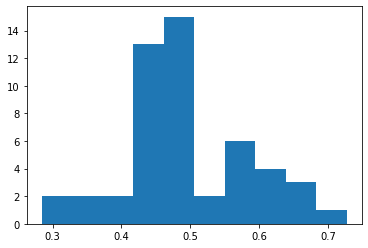

In [40]:
from matplotlib import pyplot as plt 

data = plt.hist(dists)